## 5.5 手書き数字分類

- MNISTと呼ばれるデータセットを用いる
    - 28 x 28 ピクセル、白黒
    - 訓練セット60000, テストセット10000
    - 1998年にNIST(米国の国立研究所)が作成
    - 当時は非常に難しいタスクだった

### 5.5.1 データセットのロード

PyTorch 組み込みのルーチンを使って読み込む

In [1]:
import torch
import torchvision.datasets

In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])
batch_size = 64

train_data = torchvision.datasets.MNIST(root='data', train=True, 
                                        download=True, transform=transform)
test_data = torchvision.datasets.MNIST(root='data', train=False, 
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size, shuffle=True)

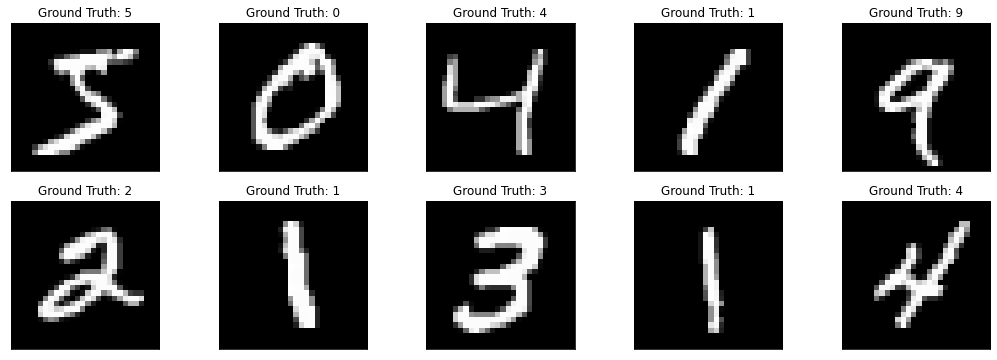

In [3]:
import matplotlib.pyplot as plt

label = train_data.targets.detach().numpy()
data = train_data.data.detach().numpy()

_, axes = plt.subplots(2, 5, figsize=(18, 6))

for i in range(10):
  ax = axes[i//5][i%5]
  ax.imshow(data[i], cmap='gray', interpolation='none')
  ax.set_title("Ground Truth: {}".format(label[i]))
  ax.set_xticks([])
  ax.set_yticks([])


### 5.5.2 ネットワークの作成

簡単なConvolusion networkを作る。
- Conv + Max_pool + Conv + Max_pool + FC + FC


<img src="images/mnist_conv_crop.svg" width="800" />

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [5]:

n_epochs = 3
learning_rate = 0.01
momentum = 0.5
log_interval = 10

network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

#### ドロップアウトについて

- 訓練時に一定の確率で、ネットワーク出力をマスクする
- 推論時にはすべてのネットワークを使って予測を行う

目的
- ネットワークが訓練セットに対して過剰適合になることを防ぐ
- ネットワークが偏りなく訓練されるようにする

副作用
- 訓練時のロスが高めに、正解率が低めになる

### 5.5.3 訓練の実行

In [6]:
# 訓練する関数

def train(epoch):
  network.train()           # モード切替
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)  # ここでネットワークにデータを流して、出力を得る
    loss = F.nll_loss(output, target)  # ロスを計算
    loss.backward()         # 誤差逆伝播法で各重みに対する勾配を計算
    optimizer.step()        # 計算した勾配を使って、重みを更新

    # これ以降はデータをプロットするためのコード
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append((batch_idx*64) + 
                            ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'results/model.pth')
      torch.save(optimizer.state_dict(), 'results/optimizer.pth')

In [7]:
# 評価する関数

def test(loader, label, accuracy_list):
  network.eval()           # モード切替
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(loader.dataset)
  if label == "Test":
    test_losses.append(test_loss)
  acc = 100. * correct / len(loader.dataset)
  print('\n {} set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
    label, test_loss, correct, len(loader.dataset), acc))
  accuracy_list.append(acc)

In [8]:
# 記録用配列の初期化

train_losses = []
train_counter = []
train_acc = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
test_acc = []


In [9]:
# hideoutput
# 訓練ループ

import os
os.makedirs("results", exist_ok=True)

test(train_loader, 'Train', train_acc)
test(test_loader, 'Test', test_acc)
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test(train_loader, 'Train', train_acc)
  test(test_loader, 'Test', test_acc)

/var/folders/k3/2gmshxgn6hs5rh72s2w6gz900000gn/T/ipykernel_54102/1255250890.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/Users/nakada/.pyenv/versions/anaconda3-2022.05/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



 Train set: Avg. loss: 2.2978, Accuracy: 7346/60000 (12%)

 Test set: Avg. loss: 2.2975, Accuracy: 1237/10000 (12%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.330096
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.278922
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.285444
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.196463
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.189074
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.163518
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.085926
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.039947
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.981258
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.757751
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.574803
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.483390
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.424584
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.061126
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.191854
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.082677
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.093459
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.056582
Train Epoch:

Text(0, 0.5, 'negative log likelihood loss')

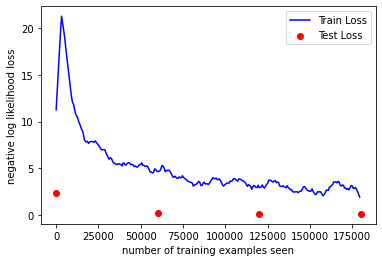

In [10]:
# ロスをプロット

# ロスの移動平均を計算
import numpy as np
t_l = np.array(train_losses)
t_l_a = np.convolve(t_l, np.ones(10))
t_l_a = t_l_a[4:-5]

plt.plot(train_counter, t_l_a, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

(90.0, 100.0)

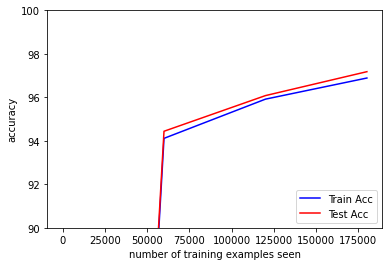

In [14]:
plt.plot(test_counter, train_acc, color='blue')
plt.plot(test_counter, test_acc, color='red')
plt.legend(['Train Acc', 'Test Acc'], loc='lower right')
plt.xlabel('number of training examples seen')
plt.ylabel('accuracy')
plt.ylim(90, 100)